In [2]:
#import packages
from nipype.interfaces.io import DataSink, SelectFiles, DataGrabber # Data i/o
from nipype.interfaces.utility import IdentityInterface, Function     # utility
from nipype.pipeline.engine import Node, Workflow, MapNode, JoinNode        # pypeline engine
from pandas import DataFrame, Series,read_csv

#set output file type for FSL to NIFTI_GZ
from nipype.interfaces.fsl.preprocess import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# Set study variables
#studyhome = '/Users/catcamacho/Box/SNAP/BABIES'
studyhome = '/home/camachocm2/Analysis/SNAP'
raw_data = studyhome + '/raw'
preproc_dir = studyhome + '/processed/preproc'
output_dir = studyhome + '/processed/network_analysis'
workflow_dir = studyhome + '/workflows'
subjects_info = read_csv(studyhome + '/misc/rest_subjects_info.csv',index_col=None, dtype={'subject_id':str})
subjects_info = subjects_info[subjects_info['usable']==1]
subjects_info['subject_id'] = subjects_info['subject_id'].apply(lambda x: x.zfill(4))
subjects_list = subjects_info['subject_id'].tolist()

template_atlas = studyhome + '/rois/language_rois_NRN.nii.gz'
template_atlas_key = studyhome + '/rois/language_rois_key_NRN.csv'

proc_cores = 6 # number of cores of processing for the workflows

200121-08:43:07,862 nipype.utils INFO:
	 Running nipype version 1.2.3 (latest: 1.4.0)


In [3]:
def correlation_matrix(func,atlas,atlas_labels):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from nilearn.input_data import NiftiLabelsMasker
    from nilearn.connectome import ConnectivityMeasure
    from nilearn import plotting
    from pandas import read_csv, DataFrame
    import matplotlib.pyplot as plt

    labels_df = read_csv(atlas_labels, index_col=None)
    labels = labels_df['region_name']
    masker = NiftiLabelsMasker(labels_img=atlas, standardize=True)
    time_series = masker.fit_transform(func)
    ts_df = DataFrame(time_series, columns=labels)
    ts_df.to_csv('time_series.csv')

    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    corr_mat_df = DataFrame(correlation_matrix,columns=labels,index=labels)
    corr_mat_df.to_csv('correlation_matrix.csv')

    plt.figure()
    plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                         vmax=0.8, vmin=-0.8, reorder=True)
    plt.savefig('corr_matrix.svg')
    plt.close()
    
    sub_atlas_timeseries = abspath('time_series.csv')
    corr_mat_fig = abspath('corr_matrix.svg')
    corr_matrix = abspath('correlation_matrix.csv')
    
    return(corr_matrix, sub_atlas_timeseries, corr_mat_fig)

In [3]:
## File handling Nodes

# Identity node- select subjects
infosource = Node(IdentityInterface(fields=['subject_id']),
                     name='infosource')
infosource.iterables = ('subject_id', subjects_list)

# Datasink- where our select outputs will go
substitutions = [('_subject_id_', '')]
datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir
datasink.inputs.substitutions = substitutions

# Data grabber
file_template = {'func': preproc_dir + '/fully_processed_func/{subject_id}/final_proc_func.nii.gz'}
selectfiles = Node(SelectFiles(file_template), name='selectfiles')

calc_connectivity = Node(Function(input_names=['func','atlas','atlas_labels'], 
                                  output_names=['corr_matrix','sub_atlas_timeseries','corr_mat_fig'], 
                                  function=correlation_matrix), 
                         name='calc_connectivity')
calc_connectivity.inputs.atlas = template_atlas
calc_connectivity.inputs.atlas_labels = template_atlas_key

In [ ]:
connect_flow = Workflow(name='connect_flow')
connect_flow.connect([(infosource,selectfiles, [('subject_id','subject_id')]),
                      (selectfiles, calc_connectivity, [('func','func')]),
                      
                      (calc_connectivity, datasink, [('corr_matrix','correlation_matrix'),
                                                     ('corr_mat_fig','corr_matrix_plot'),
                                                     ('sub_atlas_timeseries','sub_atlas_timeseries')])
                     ])

connect_flow.base_dir = workflow_dir
connect_flow.write_graph(graph2use='flat')
connect_flow.run('MultiProc', plugin_args={'n_procs': 10, 'memory_gb':30})

<Figure size 432x288 with 0 Axes>

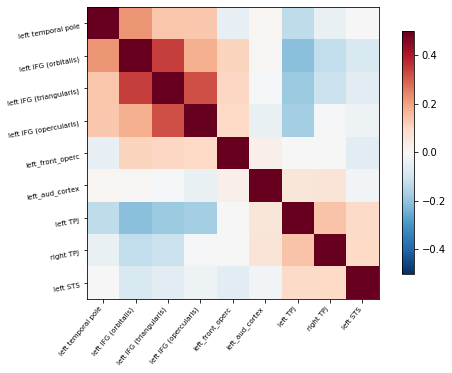

In [11]:
from nilearn import plotting
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt
import numpy as np

labels_df = read_csv(template_atlas_key, index_col=None)
labels = labels_df['region_name']

group_conn_data = read_csv(output_dir + '/correlation_matrix/{0}/correlation_matrix.csv'.format(subjects_list[0]), index_col=0)
group_conn_mat = group_conn_data.to_numpy()
group_conn_mat = np.expand_dims(group_conn_mat, axis=2)

for sub in subjects_list[1:]:
    temp = read_csv(output_dir + '/correlation_matrix/{0}/correlation_matrix.csv'.format(sub), index_col=0)
    temp_mat = np.expand_dims(temp.to_numpy(),axis=2)
    group_conn_mat = np.concatenate((group_conn_mat,temp_mat),axis=2)

group_conn_mat[((group_conn_mat<0.1) & (group_conn_mat>-0.1))]=0
mean_conn_data = np.average(group_conn_mat,axis=2)#,weights=subjects_info['age_scan'])

plt.figure()
plotting.plot_matrix(mean_conn_data, figure=(6, 6), labels=labels,
                     vmax=0.5, vmin=-0.5, reorder=True)
plt.savefig(output_dir+'/group_mean_corr_matrix.png')
plt.show()
plt.close()

the silhouette score is: 0.5250427951676483


<Figure size 432x288 with 0 Axes>

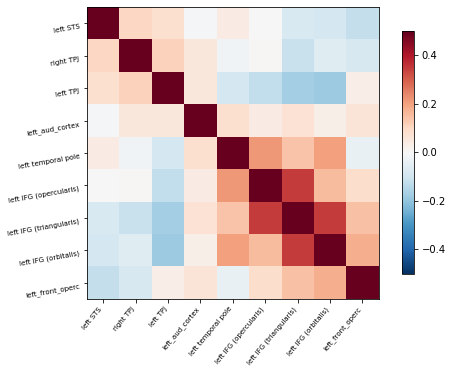

<Figure size 432x288 with 0 Axes>

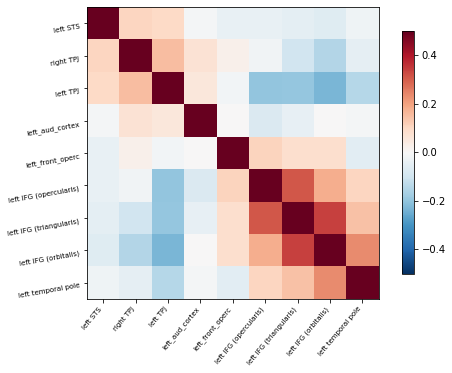

In [12]:
from nilearn.connectome import ConnectivityMeasure
from pandas import read_csv, DataFrame
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt


labels_df = read_csv(template_atlas_key, index_col=None)
labels = labels_df['region_name']

all_subs = []
for sub in subjects_list:
    ts = read_csv(output_dir + '/sub_atlas_timeseries/{0}/time_series.csv'.format(sub))
    ts=ts.to_numpy()
    all_subs.append(ts)
    
correlation_measure = ConnectivityMeasure(kind='tangent', vectorize=True)
all_con = correlation_measure.fit_transform(all_subs)
all_con[all_con<0.05]=0

#pca = PCA(n_components=1)
#pca.fit(all_con.T)
#print(pca.explained_variance_)
#components = pca.components_
#components = components

clust = KMeans(n_clusters=2,random_state=1)
#clust=AgglomerativeClustering(n_clusters=2, linkage='ward')
clust.fit(all_con)

subjects_info['kmeans_tan_labels'] = clust.labels_

print('the silhouette score is: {0}'.format(silhouette_score(all_con,clust.labels_,random_state=1)))
for group in np.unique(clust.labels_):
    subgroup_info = subjects_info[subjects_info['kmeans_tan_labels']==group]
    subs = subgroup_info['subject_id'].tolist()
    group_conn_data = read_csv(output_dir + '/correlation_matrix/{0}/correlation_matrix.csv'.format(subs[0]), index_col=0)
    group_conn_mat = group_conn_data.to_numpy()
    group_conn_mat = np.expand_dims(group_conn_mat, axis=2)
    group_conn_mat[((group_conn_mat<0.1) & (group_conn_mat>-0.1))]=0

    for sub in subs[1:]:
        temp = read_csv(output_dir + '/correlation_matrix/{0}/correlation_matrix.csv'.format(sub), index_col=0)
        temp_mat = np.expand_dims(temp.to_numpy(),axis=2)
        group_conn_mat = np.concatenate((group_conn_mat,temp_mat),axis=2)

    mean_conn_data = np.average(group_conn_mat,axis=2)#,weights=subgroup_info['age_scan'])

    plt.figure()
    plotting.plot_matrix(mean_conn_data, figure=(6, 6), labels=labels,
                         vmax=0.5, vmin=-0.5, reorder=True)
    plt.savefig(output_dir+'/group_{0}_mean_corr_matrix.png'.format(group))
    plt.show()
    plt.close()

In [5]:
import pandas as pd
pd.set_option('display.max_columns',50)
subjects_info.groupby('kmeans_tan_labels').describe()

male                                              age_scan  \
                  count      mean       std  min  25%  50%  75%  max    count   
kmeans_tan_labels                                                               
0                  19.0  0.421053  0.507257  0.0  0.0  0.0  1.0  1.0     19.0   
1                  48.0  0.520833  0.504852  0.0  0.0  1.0  1.0  1.0     48.0   

                                                                         \
                        mean       std        min        25%        50%   
kmeans_tan_labels                                                         
0                  29.240602  1.924336  25.857143  28.142857  29.000000   
1                  29.619048  2.452915  26.000000  28.392857  29.142857   

                                        age_inlab                       \
                         75%        max     count       mean       std   
kmeans_tan_labels                                                        
0                  30.357143  33.285714      19.0  26.285673  1.519492   
1                  30.464286  36.857143      48.0  26.533881  2.003218   

                                                                          \
                         min        25%        50%        75%        max   
kmeans_tan_labels                                                          
0                  24.060233  25.270363  26.053388  26.836413  29.470226   
1                  20.928131  25.590691  26.195756  27.370294  32.317591   

                  usable_trs                                              \
                       count        mean        std    min    25%    50%   
kmeans_tan_labels                                                          
0                       19.0  275.210526  11.414313  242.0  272.5  281.0   
1                       48.0  138.312500   4.058908  121.0  137.0  140.5   

                                usable_minutes                       \
                     75%    max          count       mean       std   
kmeans_tan_labels                                                     
0                  282.0  282.0           19.0  11.467105  0.475596   
1                  141.0  141.0           48.0   5.763021  0.169121   

                                                                   usable  \
                         min        25%        50%     75%     max  count   
kmeans_tan_labels                                                           
0                  10.083333  11.354167  11.708333  11.750  11.750   19.0   
1                   5.041667   5.708333   5.854167   5.875   5.875   48.0   

                                                      
                  mean  std  min  25%  50%  75%  max  
kmeans_tan_labels                                     
0                  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
1                  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [19]:
subjects_info.to_csv('sibjects_info_with_cluster_groups.csv')

In [ ]:
from nilearn.connectome import ConnectivityMeasure
from pandas import read_csv, DataFrame
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

all_subs = []
for sub in subjects_list:
    ts = read_csv(output_dir + '/sub_atlas_timeseries/{0}/time_series.csv'.format(sub))
    ts=ts.to_numpy()
    all_subs.append(ts)
    
correlation_measure = ConnectivityMeasure(kind='tangent', vectorize=True, discard_diagonal=True)
all_con = correlation_measure.fit_transform(all_subs)
all_con[all_con<0.05]=0
print(all_con.shape)
#pca = PCA(n_components=1)
#pca.fit(all_con.T)
#print(pca.explained_variance_)
#components = pca.components_
#components = components

#clust = KMeans(n_clusters=2,random_state=1)
clust=AgglomerativeClustering(n_clusters=4, linkage='ward')
clust.fit(all_con)
print('the silhouette score is: {0}'.format(silhouette_score(all_con,clust.labels_,random_state=1)))

print(clust.labels_.shape)

In [ ]:
correlation_measure.transform

In [ ]:
modules = correlation_measure.inverse_transform(clust.labels_)
print(modules)

plt.figure()
plotting.plot_matrix(modules, figure=(6, 6), labels=labels,diagonal=None)
#plt.savefig(output_dir+'/group_mean_corr_matrix.png')
plt.show()
plt.close()